In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import jax.numpy as jnp
import numpy as np
import optax
from jax import random, jit, vjp, grad, vmap
import jax.flatten_util as flat_utl
from jax.experimental.host_callback import call
from tensorflow_probability.substrates import jax as tfp
from pyDOE import lhs
import functools
import matplotlib
from matplotlib import gridspec, pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'Times New Roman'
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

np.set_printoptions(threshold=np.inf)

## Neural Network Functions

In [2]:
# initialize the neural network weights and biases
# NN is a list of tuples containing weight/bias list pairs for each layer of the NN
def init_MLP(parent_key, layer_widths):
    params = []
    keys = random.split(parent_key, num=len(layer_widths) - 1)
    # create the weights and biases for the network
    for in_dim, out_dim, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = random.split(key)
        xavier_stddev = jnp.sqrt(2 / (in_dim + out_dim))
        params.append(
            [random.truncated_normal(weight_key, -2, 2, shape=(in_dim, out_dim)) * xavier_stddev,
             random.truncated_normal(bias_key, -2, 2, shape=(out_dim,)) * xavier_stddev]
        )
    return params


# define the basic formation of neural network
def neural_net(params, z, limit, scl, act_s=0):
    '''
    :param params: weights and biases
    :param x: input data [matrix with shape [N, m]]; m is number of inputs)
    :param limit: characteristic scale for normalizeation [matrx with shape [2, m]]
    :param sgn:  1 for even function and -1 for odd function
    :return: neural network output [matrix with shape [N, n]]; n is number of outputs)
    '''
    lb = limit[0]  # lower bound for each input
    ub = limit[1]  # upper bound for each input

    # choose the activation function
    actv = [jnp.tanh, jnp.sin][act_s]
    # normalize the input
    H = 2.0 * (z - lb) / (ub - lb) - 1.0
    # separate the first, hidden and last layers
    first, *hidden, last = params
    # calculate the first layers output with right scale
    H = actv(jnp.dot(H, first[0]) * scl + first[1])
    # calculate the middle layers output
    for layer in hidden:
        H = jnp.tanh(jnp.dot(H, layer[0]) + layer[1])
    # no activation function for last layer 
    var = jnp.dot(H, last[0]) + last[1]
    return var

# generate weights and biases for all variables of CLM problem
def sol_init_MLP(parent_key, n_hl, n_unit):
    '''
    :param n_hl: number of hidden layers [int]
    :param n_unit: number of units in each layer [int]
    '''
    layers = [1] + n_hl * [n_unit] + [1]
    # generate the random key for each network
    keys = random.split(parent_key, 1)
    # generate weights and biases for
    params_u = init_MLP(keys[0], layers)
    return dict(net_u=params_u)


# wrapper to create solution function with given domain size
def sol_pred_create(limit, scl, act_s=0):
    '''
    :param limit: domain size of the input
    :return: function of the solution (a callable)
    '''
    def f_u(params, z):
        # generate the NN
        u = neural_net(params['net_u'], z, limit, scl, act_s)
        return u
    return f_u

def mNN_pred_create(f_u, limit, scl, epsil, act_s=0):
    '''
    :param f_u: sum of previous stage network
    :param limit: domain size of the input
    :return: function of the solution (a callable)
    '''
    def f_comb(params, z):
        # generate the NN
        u_now = neural_net(params['net_u'], z, limit, scl, act_s)
        u = f_u(z) + epsil * u_now
        return u
    return f_comb

## Lower-level PINN Functions

In [3]:
# generate matrix required for vjp for vector gradient
def vgmat(z, n_out, idx=None):
    '''
    :param n_out: number of output variables
    :param idx: indice (list) of the output variable to take the gradient
    '''
    if idx is None:
        idx = range(n_out)
    # obtain the number of index
    n_idx = len(idx)
    # obtain the number of input points
    n_pt = z.shape[0]
    # determine the shape of the gradient matrix
    mat_shape = [n_idx, n_pt, n_out]
    # create the zero matrix based on the shape
    mat = jnp.zeros(mat_shape)
    # choose the associated element in the matrix to 1
    for l, ii in zip(range(n_idx), idx):
        mat = mat.at[l, :, ii].set(1.)
    return mat


# vector gradient of the output wrt input
def vectgrad(func, z):
    # obtain the output and the gradient function
    sol, vjp_fn = vjp(func, z)
    # determine the mat grad
    mat = vgmat(z, sol.shape[1])
    # calculate the gradient of each output with respect to each input
    grad_sol = vmap(vjp_fn, in_axes=0)(mat)[0]
    # calculate the total partial derivative of output with input
    n_pd = z.shape[1] * sol.shape[1]
    # reshape the derivative of output wrt input
    grad_all = grad_sol.transpose(1, 0, 2).reshape(z.shape[0], n_pd)
    return grad_all, sol

## Target Function

In [1]:
def func(u, x):
    return u + x

# governing equation for ODE du/dx = u + x
def gov_eqn(f_u, x):
    # calculate the output and its derivative with original coordinates
    u_x, u = vectgrad(f_u, x)
    # calculate the residue of the CCF equation
    f = u_x - (u + x)
    return f

def gov_d3_eqn(f_u, z, gov_eqn):
    # allocate the value to each variable
    fc_res = lambda z: gov_eqn(f_u, z)
    # calculate the residue of higher derivative of CCF equation
    dfunc = lambda z: vectgrad(fc_res, z)[0]
    # calculate the residue of the first and second derivative of CCF equation
    d2f, df = vectgrad(dfunc, z)
    return df, d2f

# used for plotting vs exact solution
def fg(x):
    u = jnp.exp(x) - x - 1
    return u

IndentationError: expected an indented block after function definition on line 1 (2089469258.py, line 4)

## Loss/Optimization Functions

In [5]:
# define the mean squared error
def ms_error(diff):
    return jnp.mean(jnp.square(diff), axis=0)

def loss_create(predf_u, cond, lw, loss_ref, gov_eqn, gov_d3_eqn):
    '''
    a function factory to create the loss function based on given info
    :param loss_ref: loss value at the initial of the training
    :return: a loss function (callable)
    '''

    # loss function used for the PINN training
    def loss_fun(params, data):
        # create the function for gradient calculation involves input Z only
        f_u = lambda z: predf_u(params, z)
        # load the data of normalization condition
        z_nm = cond['cond_nm'][0]
        u_nm = cond['cond_nm'][1]

        # load the position and weight of collocation points
        z_col = data['z_col']

        # calculate the gradient of phi at origin
        u_nm_p = f_u(z_nm)

        # calculate the residue of equation
        f = gov_eqn(f_u, z_col)
        # calculate the residue of first and second derivative
        df, d2f = gov_d3_eqn(f_u, z_col, gov_eqn)

        # calculate the mean squared root error of normalization cond.
        norm_err = ms_error(u_nm_p - u_nm)
        # calculate the error of far-field exponent cond.
        data_err = jnp.hstack([norm_err])

        # calculate the mean squared root error of equation
        eqn_err_f = ms_error(f)
        eqn_err_df = ms_error(df)
        eqn_err_d2f = ms_error(d2f)
        eqn_err = jnp.hstack([eqn_err_f, eqn_err_df])

        # set the weight for each condition and equation
        data_weight = jnp.array([1.])
        eqn_weight = jnp.array([1., lw[1]])

        # calculate the overall data loss and equation loss
        loss_data = jnp.sum(data_err * data_weight)
        loss_eqn = jnp.sum(eqn_err * eqn_weight)

        # calculate the total loss
        loss = (loss_data + lw[0] * loss_eqn) / loss_ref
        # group the loss of all conditions and equations
        loss_info = jnp.hstack([jnp.array([loss, loss_data, loss_eqn]),
                                data_err, eqn_err])
        return loss, loss_info
    return loss_fun


# create the Adam minimizer 
@functools.partial(jit, static_argnames=("lossf", "opt"))
def adam_minimizer(lossf, params, data, opt, opt_state):
    """Basic gradient update step based on the opt optimizer."""
    grads, loss_info = grad(lossf, has_aux=True)(params, data)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, loss_info, opt_state


def adam_optimizer(lossf, params, dataf, epoch, lr=1e-3):
    # select the Adam as the minimizer
    opt_Adam = optax.adam(learning_rate=lr)
    # obtain the initial state of the params
    opt_state = opt_Adam.init(params)
    # pre-allocate the loss varaible
    loss_all = []
    data = dataf()
    nc = jnp.int32(jnp.round(epoch / 5))
    nc0 = 2500
    # start the training iteration
    for step in range(epoch):
        # minimize the loss function using Adam
        params, loss_info, opt_state = adam_minimizer(lossf, params, data, opt_Adam, opt_state)
        # print the loss for every 100 iteration
        if step % 100 == 0:
            print(f"Step: {step} | Loss: {loss_info[0]:.4e} |"
                  f" Loss_d: {loss_info[1]:.4e} | Loss_e: {loss_info[2]:.4e}", file=sys.stderr)
            data = dataf()

        # saving the loss 
        loss_all.append(loss_info[0:])

        if (step+1) % (2*nc0) == 0:
            lossend = np.array(loss_all[-2 * nc0:])[:, 0]
            lc1 = lossend[0: nc0]
            lc2 = lossend[nc0:]
            mm12 = jnp.abs(jnp.mean(lc1) - jnp.mean(lc2))
            stdl2 = jnp.std(lc2)
            # if the average loss improvement within 'nc' iteration is less than local loss fluctuation (std)
            if mm12 / stdl2 < 0.4:
                # reduce the learning rate by half
                lr = lr / 2
                opt_Adam = optax.adam(learning_rate=lr)
            print(f"learning rate for Adam: {lr:.4e} | mean: {mm12:.3e} | std: {stdl2:.3e}", file=sys.stderr)

    # obtain the total loss in the last iterations
    lossend = jnp.array(loss_all[-nc:])[:, 0]
    # find the minimum loss value
    # lmin = jnp.min(lossend)
    # optain the last loss value
    # llast = lossend[-1]
    # guarantee the loss value in last iteration is smaller than anyone before

    # while llast > lmin:
    #     params, loss_info, opt_state = adam_minimizer(lossf, params, data, opt_Adam, opt_state)
    #     llast = loss_info[0]
    #     # saving the loss
    #     loss_all.append(loss_info[0:])
    return params, loss_all


# A factory to create a function required by tfp.optimizer.lbfgs_minimize.
def lbfgs_function(lossf, init_params, data):
    # obtain the 1D parameters and the function that can turn back to the pytree
    _, unflat = flat_utl.ravel_pytree(init_params)

    def update(params_1d):
        # updating the model's parameters from the 1D array
        params = unflat(params_1d)
        return params

    # A function that can be used by tfp.optimizer.lbfgs_minimize.
    @jit
    def f(params_1d):
        # convert the 1d parameters back to pytree format
        params = update(params_1d)
        # calculate gradients and convert to 1D tf.Tensor
        grads, loss_info = grad(lossf, has_aux=True)(params, data)
        # convert the grad to 1d arrays
        grads_1d = flat_utl.ravel_pytree(grads)[0]
        loss_value = loss_info[0]

        # # store loss value so we can retrieve later
        call(lambda x: f.loss.append(x), loss_info[0:], result_shape=None)
        call(lambda x: print(f" Loss: {x[0]:.4e} |"
                  f" Loss_d: {x[1]:.4e} | Loss_e: {x[2]:.4e}"), loss_info)
        return loss_value, grads_1d

    # store these information as members so we can use them outside the scope
    f.update = update
    f.loss = []
    return f


# define the function to apply the L-BFGS optimizer
def lbfgs_optimizer(lossf, params, data, epoch):
    func_lbfgs = lbfgs_function(lossf, params, data)
    # convert initial model parameters to a 1D array
    init_params_1d = flat_utl.ravel_pytree(params)[0]
    # calculate the effective number of iteration
    max_nIter = jnp.int32(epoch / 3)
    # train the model with L-BFGS solver
    results = tfp.optimizer.lbfgs_minimize(
        value_and_gradients_function=func_lbfgs, initial_position=init_params_1d,
        tolerance=1e-10, max_iterations=max_nIter)
    params = func_lbfgs.update(results.position)
    # history = func_lbfgs.loss
    num_iter = results.num_objective_evaluations
    loss_all = func_lbfgs.loss
    print(f" Total iterations: {num_iter}")
    return params, loss_all


"""Prepare the collocaiton points"""
def data_func_create(N_col, ds):
    # define the function that can re-sampling for each calling
    def dataf():
        # prepare the collocation points
        z_cn = (2 * lhs(1, N_col) - 1)
        z_col = jnp.sign(z_cn) * jnp.abs(z_cn) ** 1 * ds * 1.01
        # add the collocation at the boundary
        z_col = jnp.vstack([z_col, jnp.array([-ds, ds])[:, None]])
        return dict(z_col=z_col)
    return dataf

## Setup for Training

In [6]:
seed = 1234
key = random.PRNGKey(seed)
np.random.seed(seed)
keys = random.split(key, 4) # create the subkeys

# select the size of neural network
n_hl = 3
n_unit = 20

N_col = 201 # number of sampling points
ds = 1.
lmt = jnp.array([[-ds], [ds]]) # set the size of domain
total_time_range = ds * 2 # from -1 to 1

## First Stage Training

In [7]:
"""Setting up training variables and collocation points"""
scl=1
epoch1 = 5000
epoch2 = 20000
lw = [0.3, 0.2] # loss weights - lw[0] is gamma from paper, lw[1] ?

# initialize the weights and biases of the network
trained_params = sol_init_MLP(keys[0], n_hl, n_unit)

# prepare the normalization condition
z_nm = jnp.array([[0.]])
cond_nm = jnp.array([[0.]])
cond = dict(cond_nm=[z_nm, cond_nm])

# prepare the collocation points to evaluate equation gradient
dataf = data_func_create(N_col, ds)
# group all the conditions and collocation points
data = dataf()

pred_u = sol_pred_create(lmt, scl, act_s=0) # create the solution function

NN_loss = loss_create(pred_u, cond, lw, loss_ref=1, gov_eqn=gov_eqn, gov_d3_eqn=gov_d3_eqn) # calculate the loss function
loss0 = NN_loss(trained_params, data)[0]

"""First stage of training"""
lr = 1e-3
# training the neural network
trained_params, loss1 = adam_optimizer(NN_loss, trained_params, dataf, epoch1, lr=lr)
data = dataf()
trained_params, loss2 = lbfgs_optimizer(NN_loss, trained_params, data, epoch2)

# calculate the equation residue
f_u1 = lambda z: pred_u(trained_params, z)
fu1_x = lambda z: vectgrad(f_u1, z)[0]

# calculate the solution
x_star0 = jnp.linspace(-1, 1, 2501)[:, None]
x_star = jnp.sign(x_star0) * jnp.abs(x_star0) ** 1 * 1

u1_p = f_u1(x_star)
u1_xx, u1_x = vectgrad(fu1_x, x_star)
u1_g = fg(x_star)

f1_p = gov_eqn(f_u1, x_star) # residue of governing equation
df1, d2f1 = gov_d3_eqn(f_u1, x_star, gov_eqn) # residues of first and second derivatives
e1 = u1_g - u1_p

# generate the last loss
loss_all = (loss1+loss2)

Step: 0 | Loss: 1.4459e-01 | Loss_d: 6.6685e-03 | Loss_e: 4.5975e-01
Step: 100 | Loss: 4.8714e-02 | Loss_d: 5.3996e-03 | Loss_e: 1.4438e-01
Step: 200 | Loss: 1.1697e-02 | Loss_d: 7.2595e-04 | Loss_e: 3.6570e-02
Step: 300 | Loss: 4.4644e-04 | Loss_d: 7.9369e-06 | Loss_e: 1.4617e-03
Step: 400 | Loss: 1.9222e-04 | Loss_d: 7.1284e-07 | Loss_e: 6.3835e-04
Step: 500 | Loss: 1.3356e-04 | Loss_d: 3.1265e-07 | Loss_e: 4.4416e-04
Step: 600 | Loss: 1.0087e-04 | Loss_d: 2.4392e-07 | Loss_e: 3.3541e-04
Step: 700 | Loss: 7.2785e-05 | Loss_d: 2.6368e-09 | Loss_e: 2.4261e-04
Step: 800 | Loss: 5.5612e-05 | Loss_d: 1.9194e-06 | Loss_e: 1.7898e-04
Step: 900 | Loss: 3.9673e-05 | Loss_d: 1.0688e-07 | Loss_e: 1.3189e-04
Step: 1000 | Loss: 2.9670e-05 | Loss_d: 3.5341e-08 | Loss_e: 9.8782e-05
Step: 1100 | Loss: 2.3016e-05 | Loss_d: 1.7640e-07 | Loss_e: 7.6131e-05
Step: 1200 | Loss: 1.6368e-05 | Loss_d: 1.2107e-08 | Loss_e: 5.4520e-05
Step: 1300 | Loss: 2.8047e-05 | Loss_d: 1.1295e-05 | Loss_e: 5.5839e-05
Step



 Loss: 2.1457e-06 | Loss_d: 8.9252e-11 | Loss_e: 7.1521e-06
 Loss: 2.1481e-06 | Loss_d: 1.4168e-09 | Loss_e: 7.1557e-06
 Loss: 2.1456e-06 | Loss_d: 2.9878e-12 | Loss_e: 7.1521e-06
 Loss: 2.1455e-06 | Loss_d: 3.2742e-11 | Loss_e: 7.1517e-06
 Loss: 2.1455e-06 | Loss_d: 3.0727e-11 | Loss_e: 7.1517e-06
 Loss: 2.1455e-06 | Loss_d: 3.3084e-11 | Loss_e: 7.1517e-06
 Loss: 2.1454e-06 | Loss_d: 3.5527e-11 | Loss_e: 7.1512e-06
 Loss: 2.1451e-06 | Loss_d: 6.8642e-11 | Loss_e: 7.1500e-06
 Loss: 2.1467e-06 | Loss_d: 3.6722e-10 | Loss_e: 7.1545e-06
 Loss: 2.1449e-06 | Loss_d: 1.1511e-10 | Loss_e: 7.1494e-06
 Loss: 2.1447e-06 | Loss_d: 7.8874e-11 | Loss_e: 7.1486e-06
 Loss: 2.1437e-06 | Loss_d: 5.1301e-12 | Loss_e: 7.1458e-06
 Loss: 2.1461e-06 | Loss_d: 8.9708e-10 | Loss_e: 7.1505e-06
 Loss: 2.1433e-06 | Loss_d: 5.2446e-11 | Loss_e: 7.1440e-06
 Loss: 2.1417e-06 | Loss_d: 5.5068e-11 | Loss_e: 7.1388e-06
 Loss: 2.1393e-06 | Loss_d: 6.5711e-11 | Loss_e: 7.1307e-06
 Loss: 2.1393e-06 | Loss_d: 6.4269e-11

### Validation of Simple PINN

In [8]:
"""FFT Analysis of Simple PINN"""
# FFT Analysis on Residue
g = np.array(f1_p).flatten()
N = len(g)
sample_rate = N / total_time_range
# Perform FFT
T = 1.0 / sample_rate
yf1 = fftshift(fft(g))
xf1 = fftshift(fftfreq(N, T))[N//2:]
dominant_freq_idx = np.argmax(np.abs(yf1[N//2:]))
dominant_freq1 = xf1[dominant_freq_idx]
print(f"Dominant Frequency: {dominant_freq1} Hz")

# FFT Analysis on Error
g = np.array(e1).flatten().transpose()
N = len(g)
sample_rate = N / total_time_range
# Perform FFT
T = 1.0 / sample_rate
yf2 = fftshift(fft(g))
xf2 = fftshift(fftfreq(N, T))[N//2:]
dominant_freq_idx = np.argmax(np.abs(yf2[N//2:]))
dominant_freq2 = xf2[dominant_freq_idx]
print(f"Dominant Frequency: {dominant_freq2} Hz")

# Filtering noise in error for plotting purposes
e1_filtered = savgol_filter(e1.transpose(), 500, 2).transpose()

Dominant Frequency: 1.0 Hz
Dominant Frequency: 1.0 Hz


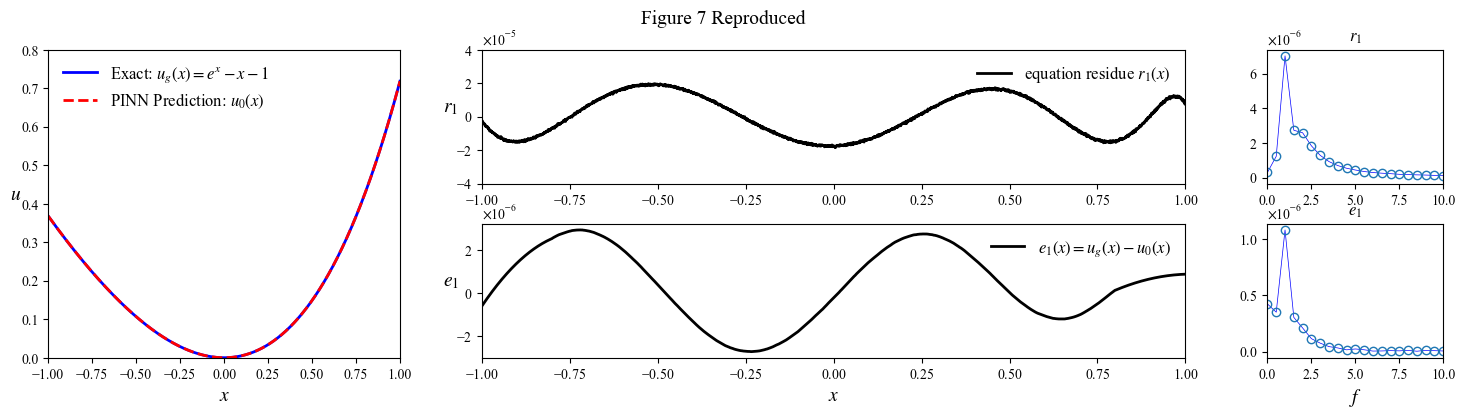

In [9]:
fig = plt.figure(figsize=(18, 4))
fig.suptitle('Figure 7 Reproduced')
fig.subplots_adjust(hspace=0.3)
gs = gridspec.GridSpec(2, 3, width_ratios=[2, 4, 1]) 
ax = plt.subplot(gs[:, 0])
ax.plot(x_star, u1_p, 'b-', linewidth=2, label=r'Exact: $u_g(x) = e^x - x - 1$')
ax.plot(x_star, u1_g, 'r--', linewidth=2, label=r'PINN Prediction: $u_0(x)$')
ax.set_xlim([-1, 1])
ax.set_ylim([0, 0.8])
ax.legend(loc='upper left', frameon=False)
ax.set_xlabel('$x$')
ax.set_ylabel('$u$', rotation=0)

ax = plt.subplot(gs[0, 1])
ax.plot(x_star, f1_p, color='black', linewidth=2, label='equation residue $r_1(x)$')
ax.set_xlim([-1, 1])
ax.set_ylim([-4e-5, 4e-5])
ax.legend(loc='upper right', frameon=False)
ax.ticklabel_format(style='sci', useMathText=True, scilimits=(0, 0))
ax.set_ylabel("$r_1$", rotation=0)

ax = plt.subplot(gs[1, 1])
ax.plot(x_star, e1_filtered, color='black', linewidth=2, label='$e_1(x) = u_g(x) - u_0(x)$')
ax.set_xlim([-1, 1])
ax.legend(frameon=False)
ax.ticklabel_format(style='sci', useMathText=True, scilimits=(0, 0))
ax.set_xlabel('$x$')
ax.set_ylabel("$e_1$", rotation=0)

ax = plt.subplot(gs[0, 2])
ax.set_title('$r_1$')
ax.plot(xf1, np.abs(yf1[N//2:]) / N, 'b', linewidth=0.5)
ax.plot(xf1, np.abs(yf1[N//2:]) / N, 'o', mfc='none')
ax.set_xlim([0, 10])
ax.ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(0, 0))

ax = plt.subplot(gs[1, 2])
ax.set_title("$e_1$")
ax.plot(xf2, np.abs(yf2[N//2:]) / N, 'b', linewidth=0.5)
ax.plot(xf2, np.abs(yf2[N//2:]) / N, 'o', mfc='none')
ax.set_xlim([0, 10])
ax.set_xlabel("$f$")
ax.ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(0, 0))

## Second Stage Training

In [10]:
"""Finding new scale factor and magnitude prefactor for stage 2"""
g = np.array(f1_p).flatten()
N = len(g)
sample_rate = N / total_time_range
# Perform FFT
T = 1.0 / sample_rate
yf = fftshift(fft(g))
xf = fftshift(fftfreq(N, T))[N//2:]
dominant_freq_idx = np.argmax(np.abs(yf[N//2:]))
dominant_freq = xf[dominant_freq_idx]
magnitude = np.abs(yf[dominant_freq_idx]) / N

print(f"Dominant Frequency: {dominant_freq} Hz")

# Calculate kappa for Stage 2
if dominant_freq < g.size / (6 * np.pi):
    scl2 = 2 * np.pi * dominant_freq
    print('Kappa 1', scl2)
else:
    print('Not enough data: Please Increase')


# find magnitude prefactor
eps_r1 = np.sqrt(1/len(f1_p) * sum(i ** 2 for i in f1_p.flatten())) # RMS of equation residue
u, x = data['z_col'].flatten(), data['z_col'].flatten()
f = func(u, x).flatten()
b_m = np.gradient(f, u) # partial of governing equation wrt highest order derivative of u in f
eps_bm = np.sqrt(1/len(b_m) * sum(i ** 2 for i in b_m))

epsil = eps_r1 / (((2 * np.pi * dominant_freq) ** 1) * eps_bm)
print("Magnitude Prefactor", epsil)


# Solve Eq. 7 for u_1 = du_1/dx + r_1/epsil_1
# transform BC to u_1(0) = (1 - u_0(0))/epsil_1


# # function is du/dx = u + x
# def func(u, x):
#     return u + x

# # governing equation for above function
# def gov_eqn(f_u, x):
#     # calculate the output and its derivative with original coordinates
#     u_x, u = vectgrad(f_u, x)
#     # calculate the residue of the CCF equation
#     f = u_x - func(u, x)
#     return f

Dominant Frequency: 1.0 Hz
Kappa 1 6.283185307179586
Magnitude Prefactor 9.587560969360004e-07


In [ ]:
"""Preparing new collocation points and NN for stage 2"""
epoch1 = 20000
epoch2 = 40000
lw = [0.02, 0.001]

dataf2 = data_func_create(N_col*2, ds) # collocation points
data2 = dataf2()

trained_params2 = sol_init_MLP(keys[1], n_hl, n_unit)

pred_u2 = mNN_pred_create(f_u1, lmt, scl2, epsil, act_s=1) # create the solution function

NN_loss2 = loss_create(pred_u2, cond, lw, loss_ref=1, gov_eqn=gov_eqn, gov_d3_eqn=gov_d3_eqn)
loss0 = NN_loss2(trained_params2, data2)[0] 
NN_loss2 = loss_create(pred_u2, cond, lw, loss_ref=loss0, gov_eqn=gov_eqn, gov_d3_eqn=gov_d3_eqn) # calculate the loss function

"""Second stage of training"""
trained_params2, loss1 = adam_optimizer(NN_loss2, trained_params2, dataf2, epoch1, lr=lr)
data2 = dataf2()
trained_params2, loss2 = lbfgs_optimizer(NN_loss2, trained_params2, data2, epoch2)

# calculate the equation residue
f_u2 = lambda z: pred_u2(trained_params2, z)
fu2_x = lambda z: vectgrad(f_u2, z)[0]

# calculate the solution
u2_p = f_u2(x_star)
u2_xx, u2_x = vectgrad(fu2_x, x_star)

f2_p = gov_eqn(f_u2, x_star)
df2, d2f2 = gov_d3_eqn(f_u2, x_star, gov_eqn)

# generate the last loss
loss_all = loss_all + (loss1+loss2)

## Third Stage Training

In [ ]:
"""Finding new scale factor and magnitude prefactor for stage 3"""
g = np.array(f2_p).flatten()
N = len(g)
sample_rate = N / total_time_range
# Perform FFT
T = 1.0 / sample_rate
yf = fft(g)
xf = fftfreq(N, T)[:N//2]
dominant_freq_idx = np.argmax(np.abs(yf[:N//2]))
dominant_freq = xf[dominant_freq_idx]
magnitude = np.abs(yf[dominant_freq_idx]) / N

print(f"Dominant Frequency: {dominant_freq} Hz")

# Calculate kappa for Stage 3
if dominant_freq < g.size / (6 * np.pi):
    scl3 = 2 * np.pi * dominant_freq
    print('Kappa 2', scl3)
else:
    print('Not enough data: Please Increase')


# find magnitude prefactor
eps_r2 = np.sqrt(1/len(f2_p) * sum(i ** 2 for i in f2_p.flatten())) # RMS of equation residue
u, x = data2['z_col'].flatten(), data2['z_col'].flatten()
f = func(u, x).flatten()
b_m = np.gradient(f, u) # partial of governing equation wrt highest order derivative of u in f
eps_bm = np.sqrt(1/len(b_m) * sum(i ** 2 for i in b_m))

epsil = eps_r2 / (((2 * np.pi * dominant_freq) ** 1) * eps_bm)
print("Magnitude Prefactor", epsil)

In [ ]:
"""preparing new collocation points"""
# collocation points
dataf3 = data_func_create(N_col*4, ds)
data3 = dataf3()

epoch1 = 60000
lw = [0.001, 0.000002]

trained_params3 = sol_init_MLP(keys[2], n_hl, n_unit)

pred_u3 = mNN_pred_create(f_u2, lmt, scl3, epsil, act_s=1) # create the solution function

NN_loss3 = loss_create(pred_u3, cond, lw, loss_ref=1, gov_eqn=gov_eqn, gov_d3_eqn=gov_d3_eqn)
loss0 = NN_loss3(trained_params3, data3)[0]
NN_loss3 = loss_create(pred_u3, cond, lw, loss_ref=loss0, gov_eqn=gov_eqn, gov_d3_eqn=gov_d3_eqn) # calculate the loss function

"""Third stage of training"""
trained_params3, loss1 = adam_optimizer(NN_loss3, trained_params3, dataf3, epoch1, lr=lr)

# calculate the equation residue
f_u3 = lambda z: pred_u3(trained_params3, z)
fu3_x = lambda z: vectgrad(f_u3, z)[0]

# calculate the solution
u3_p = f_u3(x_star)
u3_xx, u3_x = vectgrad(fu3_x, x_star)

f3_p = gov_eqn(f_u3, x_star)
df3, d2f3 = gov_d3_eqn(f_u3, x_star, gov_eqn)

# generate the last loss
loss_all = loss_all + loss1

## Plots

In [ ]:
fig = plt.figure(figsize=[10, 16], dpi=100)

ax = plt.subplot(411)
ax.plot(x_star, fg(x_star), 'b-', linewidth = 2, label = 'Exact')
ax.plot(x_star, u3_p, 'r--', linewidth = 2, label = 'NN')
ax.set_ylabel('$x$', fontsize=15, rotation = 0)
ax.set_title('Function', fontsize=10)
ax.set_xlim([-1, 1])

ax1 = plt.subplot(412)
ax1.plot(x_star, f1_p, 'b-', linewidth=2, label='Exact')
ax1.set_ylabel('$x$', fontsize=15, rotation=0)
ax1.set_title('Residue order 1', fontsize=10)
ax1.set_xlim([-1.0, 1.0])


ax2 = plt.subplot(413)
ax2.plot(x_star, f2_p, 'b-', linewidth=2, label='Exact')
ax2.set_ylabel('$x$', fontsize = 15, rotation = 0)
ax2.set_title('Residue order 2', fontsize = 10)
ax2.set_xlim([-1.0, 1.0])


ax3 = plt.subplot(414)
ax3.plot(x_star, f3_p, 'b-', linewidth=2, label='Exact')
ax3.set_xlabel('$t$', fontsize = 15)
ax3.set_ylabel('$x$', fontsize = 15, rotation = 0)
ax3.set_title('Residue order 3', fontsize = 10)
ax3.set_xlim([-1.0, 1.0])

plt.show()